In [1]:
import numpy as np
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

iris = load_iris()
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

## Loading Data 

In [2]:
x = iris.data

label = iris.target

y = np.zeros(label.shape + (3,))
y[np.arange(label.shape[0]),label] = 1

print x.shape, y.shape


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

print x_train.shape, x_test.shape, y_train.shape, y_test.shape

(150, 4) (150, 3)
(120, 4) (30, 4) (120, 3) (30, 3)


## Activation Functions

In [3]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def relu(x):
    x[x < 0] = 0
    return x

def tanh(x):
    return np.tanh(x)

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

def deriv(x, activation = 'relu'):
    if(activation == 'relu'):
        x[x > 0] = 1
        x[x < 0] = 0
        return x

## Function to Initialize Weights

In [4]:
def xavier_initializer(fan_in,fan_out):
    return np.random.normal(0,np.sqrt(2*1.0/(fan_in+fan_out)),(fan_out,fan_in+1))

## Compute the Output shapes of each layer

In [5]:
def get_model(feed_dict):
    feed_dict['input_shape'] = feed_dict['train_input'].shape[1:]
    inp_shape = feed_dict['input_shape']
    feed_dict['output'] = []
    layers = feed_dict['layers']
    
    for i in range(len(layers)):
        output_shape = (layers[i]['nodes'],1)
        out_dict = {'layer_number': i , 'type': 'fc', 'output_shape': output_shape}
        feed_dict['output'].append(out_dict)
        inp_shape = output_shape
    return feed_dict

## Fully Connected layer

In [6]:
def fully_connected(inp, weights,  nodes, activation):
    inp = np.asarray(inp).reshape(len(inp),1)
    inp = np.vstack((np.array(inp),1))
    #initiazing weights
#     weights = np.asmatrix(np.random.rand(nodes, len(inp)))
    output_raw = np.matmul(weights, inp)
    #normalizing the output to ensure no overflow in exp
#     print np.max(output_raw)
    output_raw = output_raw 
    #applying activation function
    if(activation == 'sigmoid'):
        output = sigmoid(output_raw)
    elif(activation == 'relu'):
        output = relu(output_raw)
    elif(activation == 'tanh'):
        output = tanh(output_raw)
    elif(activation == 'softmax'):
        output = softmax(output_raw)
    else:
        output = output_raw
    #making the output vector as column matrix
    if(output.shape[0] == 1):
        output = np.moveaxis(output, 0,1)
        output_raw = np.moveaxis(output_raw, 0,1)
    return output, output_raw

## Defining the model

In [7]:
feed_dict = {}
feed_dict['train_input'] = x_train
feed_dict['train_label'] = y_train
feed_dict['test_input'] = x_test
feed_dict['test_label'] = y_test
feed_dict['const_delta'] = 1e-9
feed_dict['learning_rate_epsilon'] = 1e-2
feed_dict['epochs'] = 2000
feed_dict['batch_size'] = 5
feed_dict['layers'] = [{'type': 'fc',  'nodes': 10, 'activation' : 'relu'},
                       {'type': 'fc',  'nodes': 10, 'activation' : 'relu'},
                       {'type': 'fc',  'nodes': 3, 'activation' : 'softmax'}]

## Computing the outputs and initializng the weights

In [8]:
feed_dict = get_model(feed_dict)

print 'output shapes:'
for i in range(len(feed_dict['layers'])):
    print feed_dict['layers'][i]['type']+str(i) , ': ', feed_dict['output'][i]['output_shape']

print("\n")

feed_dict['output'][0]['weights'] = xavier_initializer(feed_dict['input_shape'][0], feed_dict['layers'][0]['nodes'])
feed_dict['output'][1]['weights'] = xavier_initializer(feed_dict['output'][0]['output_shape'][0], feed_dict['layers'][1]['nodes'])
feed_dict['output'][2]['weights'] = xavier_initializer(feed_dict['output'][1]['output_shape'][0], feed_dict['layers'][2]['nodes'])

print 'weight matrices shapes (with biases):'
print feed_dict['layers'][0]['type']+str(0),feed_dict['output'][0]['weights'].shape
print feed_dict['layers'][1]['type']+str(1),feed_dict['output'][1]['weights'].shape
print feed_dict['layers'][2]['type']+str(2),feed_dict['output'][2]['weights'].shape

output shapes:
fc0 :  (10, 1)
fc1 :  (10, 1)
fc2 :  (3, 1)


weight matrices shapes (with biases):
fc0 (10, 5)
fc1 (10, 11)
fc2 (3, 11)


In [9]:
epochs = feed_dict['epochs']
no_samples = len(x_train)
batch_size = feed_dict['batch_size']
no_batches = no_samples/batch_size

In [10]:
tpp = [np.random.rand(3,3), np.random.rand(4,5,6), np.random.rand(5,8,7,6,5)]
print tpp[1].shape

(4, 5, 6)


In [11]:
layers = feed_dict['layers']
train_losses = []
feed_dict['rr'] = [np.zeros(feed_dict['output'][0]['weights'].shape), np.zeros(feed_dict['output'][1]['weights'].shape), np.zeros(feed_dict['output'][2]['weights'].shape)]
for epoch in range(epochs):
    cost_per_epoch = 0
    #shuffling the data
    s = np.arange(feed_dict['train_input'].shape[0])
    np.random.shuffle(s)
    feed_dict['train_input'] = feed_dict['train_input'][s]
    feed_dict['train_label'] = feed_dict['train_label'][s]
    for batch in range(no_batches):
        # weight matrices for sum of updates of batch
        weights_fc_0 = np.zeros(feed_dict['output'][0]['weights'].shape)
        weights_fc_1 = np.zeros(feed_dict['output'][1]['weights'].shape)
        weights_fc_2 = np.zeros(feed_dict['output'][2]['weights'].shape)
        for i in range(batch_size):
            #feeding forward
            feed_dict['output'][0]['output'], feed_dict['output'][0]['output_raw'] = fully_connected(feed_dict['train_input'][i + batch * batch_size], weights = feed_dict['output'][0]['weights'], nodes = layers[0]['nodes'], activation = layers[0]['activation'])
            feed_dict['output'][1]['output'], feed_dict['output'][1]['output_raw'] = fully_connected(feed_dict['output'][0]['output'], weights = feed_dict['output'][1]['weights'], nodes = layers[1]['nodes'], activation = layers[1]['activation'])
            feed_dict['output'][2]['output'], feed_dict['output'][2]['output_raw'] = fully_connected(feed_dict['output'][1]['output'], weights = feed_dict['output'][2]['weights'], nodes = layers[2]['nodes'], activation = layers[2]['activation'])
            
            #cost calculation
            cost_per_epoch = cost_per_epoch - np.log(feed_dict['output'][2]['output'][np.argmax(feed_dict['train_label'][i + batch * batch_size])])
            
            #calculating the gradients
            feed_dict['output'][2]['semi_update'] = feed_dict['output'][2]['output'] - feed_dict['train_label'][i + batch * batch_size].reshape(-1,1)
            feed_dict['output'][2]['update'] = np.matmul(feed_dict['output'][2]['semi_update'] , np.transpose(np.vstack((feed_dict['output'][1]['output'],1))))
            
            temp = feed_dict['output'][2]['weights'][:,0:feed_dict['output'][2]['weights'].shape[1]-1]
            feed_dict['output'][1]['semi_update'] = np.matmul(np.transpose(temp), feed_dict['output'][2]['semi_update']) * deriv(feed_dict['output'][1]['output_raw'])
            feed_dict['output'][1]['update'] = np.matmul(feed_dict['output'][1]['semi_update'] , np.transpose(np.vstack((feed_dict['output'][0]['output'],1))))
            
            temp = feed_dict['output'][1]['weights'][:,0:feed_dict['output'][1]['weights'].shape[1]-1]
            feed_dict['output'][0]['semi_update'] = np.matmul(np.transpose(temp), feed_dict['output'][1]['semi_update']) * deriv(feed_dict['output'][0]['output_raw'])
            feed_dict['output'][0]['update'] = np.matmul(feed_dict['output'][0]['semi_update'],np.transpose(np.vstack((np.expand_dims(feed_dict['train_input'][i + batch * batch_size],axis = 1),1))))
            
            weights_fc_0 += feed_dict['output'][0]['update']
            weights_fc_1 += feed_dict['output'][1]['update']
            weights_fc_2 += feed_dict['output'][2]['update']
            
        #updating the gradient after each batch
        feed_dict['rr'][0] = feed_dict['rr'][0] + (weights_fc_0 * weights_fc_0)
        feed_dict['rr'][1] = feed_dict['rr'][1] + (weights_fc_1 * weights_fc_1)
        feed_dict['rr'][2] = feed_dict['rr'][2] + (weights_fc_2 * weights_fc_2) 
        feed_dict['output'][0]['weights'] -= (feed_dict['learning_rate_epsilon']*weights_fc_0)/(feed_dict['const_delta'] + np.sqrt(feed_dict['rr'][0]))
        feed_dict['output'][1]['weights'] -= (feed_dict['learning_rate_epsilon']*weights_fc_1)/(feed_dict['const_delta'] + np.sqrt(feed_dict['rr'][1]))
        feed_dict['output'][2]['weights'] -= (feed_dict['learning_rate_epsilon']*weights_fc_2)/(feed_dict['const_delta'] + np.sqrt(feed_dict['rr'][2]))
        
    #printing the Average Loss after each epoch
    if((epoch+1)%50 ==0):
        print("Epoch: " + str(epoch+1) + " Loss: " + str(cost_per_epoch/no_samples))
    train_losses.append(cost_per_epoch/no_samples)

Epoch: 50 Loss: [0.29715023]
Epoch: 100 Loss: [0.21061697]
Epoch: 150 Loss: [0.16604365]
Epoch: 200 Loss: [0.14082759]
Epoch: 250 Loss: [0.12373317]
Epoch: 300 Loss: [0.11193395]
Epoch: 350 Loss: [0.10318543]
Epoch: 400 Loss: [0.0972053]
Epoch: 450 Loss: [0.09170451]
Epoch: 500 Loss: [0.08767076]
Epoch: 550 Loss: [0.08440788]
Epoch: 600 Loss: [0.08149092]
Epoch: 650 Loss: [0.07945476]
Epoch: 700 Loss: [0.07734208]
Epoch: 750 Loss: [0.075596]
Epoch: 800 Loss: [0.07348305]
Epoch: 850 Loss: [0.07224495]
Epoch: 900 Loss: [0.07059036]
Epoch: 950 Loss: [0.07007791]
Epoch: 1000 Loss: [0.06875975]
Epoch: 1050 Loss: [0.06725993]
Epoch: 1100 Loss: [0.0666131]
Epoch: 1150 Loss: [0.06559599]
Epoch: 1200 Loss: [0.06495209]
Epoch: 1250 Loss: [0.06411008]
Epoch: 1300 Loss: [0.06392253]
Epoch: 1350 Loss: [0.06299444]
Epoch: 1400 Loss: [0.06237286]
Epoch: 1450 Loss: [0.06208758]
Epoch: 1500 Loss: [0.06155842]
Epoch: 1550 Loss: [0.06108415]
Epoch: 1600 Loss: [0.06053189]
Epoch: 1650 Loss: [0.06033114]
E

## Saving the Model

In [12]:
np.save("adagrad.npy", feed_dict)

## Plotting the training loss

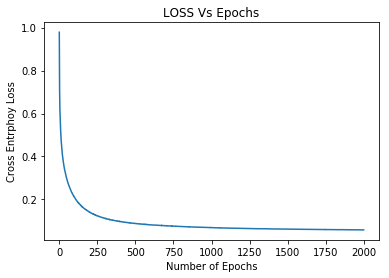

In [13]:
train_losses = np.array(train_losses)
plt.plot(train_losses)
plt.title('LOSS Vs Epochs')
plt.ylabel('Cross Entrphoy Loss')
plt.xlabel('Number of Epochs')
plt.show()

## Prediction on one sample

In [14]:
feed_dict['output'][0]['output'], feed_dict['output'][0]['output_raw'] = fully_connected(feed_dict['train_input'][0], weights = feed_dict['output'][0]['weights'], nodes = layers[0]['nodes'], activation = layers[0]['activation'])
feed_dict['output'][1]['output'], feed_dict['output'][1]['output_raw'] = fully_connected(feed_dict['output'][0]['output'], weights = feed_dict['output'][1]['weights'], nodes = layers[1]['nodes'], activation = layers[1]['activation'])
feed_dict['output'][2]['output'], feed_dict['output'][2]['output_raw'] = fully_connected(feed_dict['output'][1]['output'], weights = feed_dict['output'][2]['weights'], nodes = layers[2]['nodes'], activation = layers[2]['activation'])

print 'output of softmax for one sample:'
print feed_dict['output'][2]['output']

print '\nGround Truth of the same sample above:'
print feed_dict['train_label'][0]

output of softmax for one sample:
[[9.99982461e-01]
 [1.75390094e-05]
 [4.93348474e-13]]

Ground Truth of the same sample above:
[1. 0. 0.]


## Predicting on Test Data

In [15]:
test_predicted = []
gt = []
# print(np.argmax(out))
for i in range(feed_dict['test_input'].shape[0]):
    feed_dict['output'][0]['output'], feed_dict['output'][0]['output_raw'] = fully_connected(feed_dict['test_input'][i], weights = feed_dict['output'][0]['weights'], nodes = layers[0]['nodes'], activation = layers[0]['activation'])
    feed_dict['output'][1]['output'], feed_dict['output'][1]['output_raw'] = fully_connected(feed_dict['output'][0]['output'], weights = feed_dict['output'][1]['weights'], nodes = layers[1]['nodes'], activation = layers[1]['activation'])
    feed_dict['output'][2]['output'], feed_dict['output'][2]['output_raw'] = fully_connected(feed_dict['output'][1]['output'], weights = feed_dict['output'][2]['weights'], nodes = layers[2]['nodes'], activation = layers[2]['activation'])
    
    test_predicted.append(np.argmax(feed_dict['output'][2]['output']))
    gt.append(np.argmax(feed_dict['test_label'][i]))

## Outputs and the respective Groucd Truths

In [16]:
print 'predicted: ',test_predicted
print 'Actual   : ', gt

predicted:  [0, 0, 1, 0, 1, 1, 2, 0, 2, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 0, 0]
Actual   :  [0, 0, 1, 0, 1, 1, 2, 0, 2, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 0, 0]


## Accuracy on the Test Dataset

In [17]:
a = np.array(test_predicted) - np.array(gt)
test_accuracy = (len(a) - np.count_nonzero(a))/float(len(a))

print 'accuracy: ', str(test_accuracy)

accuracy:  1.0
